# 2D Post-stack inversion with proximal solvers

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from matplotlib.colors import LinearSegmentedColormap

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *
from pylops.basicoperators import VStack as VStacklop

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.optimization.segmentation import *

In [2]:
os.environ['NUMBA_NUM_THREADS']

'4'

In [3]:
def callback(x, xhist):
    xhist.append(x)

In [4]:
def RRE(x, xinv):
    return np.linalg.norm(x-xinv) / np.linalg.norm(x)

In [5]:
def PSNR(x, xinv):
    return 10 * np.log10(len(xinv) * np.max(xinv) / np.linalg.norm(x-xinv))

## 2D Post-stack inversion

We consider the following problem

$$
\mathbf{x} = arg min_\mathbf{x} \frac{\sigma}{2} ||\mathbf{W}\mathbf{D}\mathbf{x} - \mathbf{y} ||_2^2 + ||\mathbf{D} \mathbf{x}||_1
$$

Layered model

nt0, nx = 301, 101
dt0 = 0.004
t0 = np.arange(nt0)*dt0
ai = 1800 * np.ones(nt0)
ai[51:71] = 1900
ai[71:121] = 2100
ai[121:151] = 1600
ai[151:251] = 1900
ai2d = np.outer(ai, np.ones(nx))
m = np.log(ai2d)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.imshow(m)
ax.axis('tight');

Gas-oil-water model

nt0, nx = 301, 101
dt0 = 0.004
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

ai = 1900 * np.ones((nt0, nx))
ai[100:150] = 1400
ai[150:200] = 1600
ai[200:250] = 1800
ai[250:] = 2400

###### overburden
to = 0.
ko = 2.6e-3
ttop = x * ko + to
for ix in range(nx):
    ai[:int(ttop[ix]/dt0), ix] = 2000

###### underburden
tu = 0.65
ku = 2.6e-3
tbase = x * ku + tu
for ix in range(nx):
    ai[int(tbase[ix]/dt0):, ix] = 2000
m = np.log(ai)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.imshow(m)
ax.axis('tight');

Wedge model

nt0, nx = 301, 101
dt0 = 0.004
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

ai = 1900 * np.ones((nt0, nx))
ai[80:100] = 2200
ai[100:130] = 2100
ai[130:150] = 1700
ai[150:] = 1800

# underburden
tu = 1.02
ku = -1e-3
tbase = x * ku + tu
for ix in range(nx):
    ai[int(tbase[ix]/dt0):, ix] = 1700
m = np.log(ai)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.imshow(m)
ax.axis('tight');

Fault model

nt0, nx = 301, 101
dt0 = 0.004
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

ai = 1800 * np.ones(nt0)
ai[51:71] = 1900
ai[71:121] = 2100
ai[121:151] = 1600
ai[151:251] = 2000
ai[251:] = 2200
ai1 = np.outer(ai, np.ones(nx))
ai2d = np.roll(ai1, 32, axis=0)
ai2d[:32] = 1800

# fault
tf = 0.0
kf = 3e-3
fault = x * kf + tf
mask = np.zeros_like(ai1, dtype=int)
for ix in range(nx):
    ai2d[int(fault[ix]/dt0):, ix] = ai1[int(fault[ix]/dt0):, ix]
m = np.log(ai2d)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.imshow(m)
ax.axis('equal');

Fault model 1

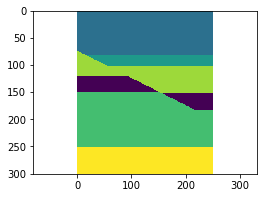

In [6]:
nt0, nx = 301, 251
dt0 = 0.004
t0 = np.arange(nt0)*dt0
dx = 4
x = np.arange(nx)*dx

ai = 1800 * np.ones(nt0)
ai[51:71] = 1900
ai[71:121] = 2100
ai[121:151] = 1600
ai[151:251] = 2000
ai[251:] = 2200
ai1 = np.outer(ai, np.ones(nx))
ai2d = np.roll(ai1, 32, axis=0)
ai2d[:32] = 1800

# fault
tf = 0.3
kf = 5e-4
fault = x * kf + tf
mask = np.zeros_like(ai1, dtype=int)
for ix in range(nx):
    ai2d[int(fault[ix]/dt0):, ix] = ai1[int(fault[ix]/dt0):, ix]
m = np.log(ai2d)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.imshow(m)#, extent=(x[0], x[-1], t0[-1], t0[0]))
ax.axis('equal');

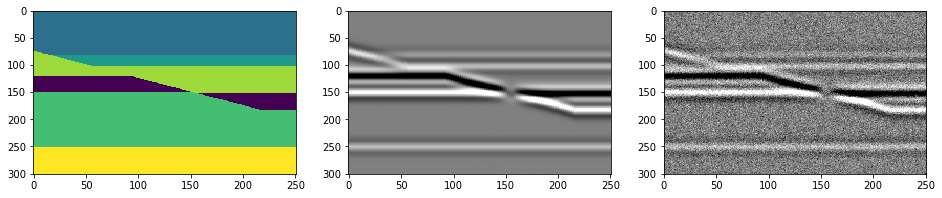

In [7]:
# smooth model
nsmooth = 20
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)

# wavelet
ntwav = 61
wav, twav, wavc = ricker(t0[:ntwav//2+1], 8)

# operator
Lop = PoststackLinearModelling(wav / 2, nt0=nt0, spatdims=nx)

# data
d = Lop * m.ravel()
d = d.reshape(nt0, nx)

# random noise
sigman = 2e-2
n = np.random.normal(0, sigman, d.shape)

# colored noise
#sigman = 1e-1
#n = filtfilt(np.ones(20)/20, 1,
#             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, d.shape).T, method='gust').T,
#             method='gust')
dn = d + n

fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].imshow(m)
axs[0].axis('tight')
axs[1].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight')
axs[2].imshow(dn, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

# FK filter to take away faults
D = np.fft.fft2(d)
D = np.fft.fftshift(D)
Mask = np.ones_like(D)
maskx = 42
Mask[:,:maskx] = 0
Mask[:,nx-maskx:] = 0
d = np.real(np.fft.ifft2(np.fft.ifftshift(D*Mask)))

plt.figure()
plt.imshow(np.abs(D))
#plt.xlim(100, 150)
#plt.ylim(100, 200)
plt.figure()
plt.imshow(np.abs(D*Mask))
#plt.xlim(100, 150)
#plt.ylim(100, 200)


fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].imshow(m)
axs[0].axis('tight')
axs[1].imshow(d, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight')
axs[2].imshow(dn, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

RRE= 0.002878966877593775
PSNR= 49.87435579334539


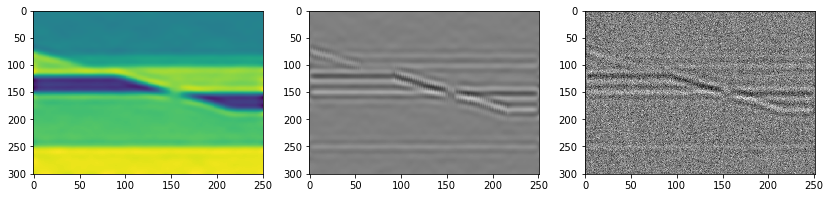

In [8]:
# L2 regularized inversion
Dop = Laplacian(dims=(nt0, nx), dtype=Lop.dtype)
minv = RegularizedInversion(Lop, [Dop], dn.ravel(),
                            x0=mback.ravel(), epsRs=[10], returninfo=False,
                            **dict(iter_lim=500, damp=1e-2))
dinv = Lop*minv

minv = minv.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

print('RRE=', RRE(m.ravel(), minv.ravel()))
print('PSNR=', PSNR(m.ravel(), minv.ravel()))

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs[0].imshow(minv)
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 75551 rows and 75551 cols
niter_outer =  10     niter_inner =   4   tol = 1.00e-10
mu = 1.00e-01         epsL1 = [0.03]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   7.55516e+00        1.370e+00        6.440e+02
     2   7.57384e+00        1.410e+00        4.481e+02
     3   7.61165e+00        1.430e+00        3.822e+02
     4   7.62778e+00        1.442e+00        3.384e+02
     5   7.63037e+00        1.450e+00        3.169e+02
     6   7.62541e+00        1.455e+00        3.015e+02
     7   7.60719e+00        1.459e+00        2.885e+02
     8   7.58112e+00        1.462e+00        2.765e+02
     9   7.55207e+00        1.464e+00        2.668e+02
    10   7.52401e+00        1.465e+00        2.616e+02

Iterations = 10        Total time (s) = 27.73
--------------------------------------------

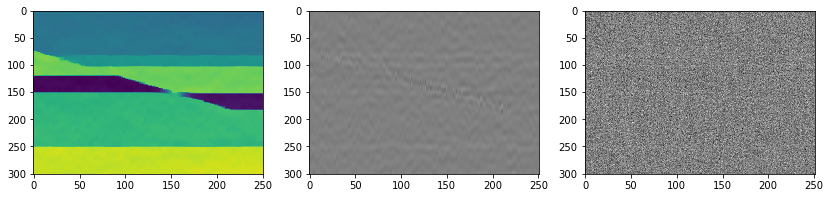

In [9]:
# SplitBregman (Blockiness-promoting inversion with anisotropic TV)
RegL1op = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
msb = SplitBregman(Lop, [RegL1op], dn.ravel(),
                   epsRL1s=[0.03], mu=0.1,
                   niter_outer=10,
                   niter_inner=4,
                   x0=mback.ravel(), show=True,
                   **dict(iter_lim=50, damp=1e-4))[0]
dinv = Lop*msb

msb = msb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

print('RRE=', RRE(m.ravel(), msb.ravel()))
print('PSNR=', PSNR(m.ravel(), msb.ravel()))

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs[0].imshow(msb)
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

RRE= 0.002131183288779854
PSNR= 51.1855305816685


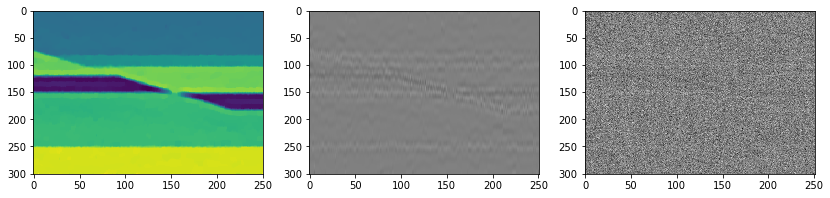

In [10]:
# L-ADMM (Blockiness-promoting inversion with isotropic TV)
sigma=0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

# approach based on 2 Lipswinch constants
#tau = 0.537669 #1. / np.real((Lop.H*Lop).eigs(neigs=1, which='LM')[0]) # optimal tau=1/maxeig(Lop^H Lop)
#mu = 0.0665 #0.99 * tau / np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0]) # optimal mu=tau/maxeig(Dop^H Dop)

# most common approach
L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)


mladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=mback.ravel(), niter=100)[0]
dinv = Lop*mladmm

mladmm = mladmm.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

print('RRE=', RRE(m.ravel(), mladmm.ravel()))
print('PSNR=', PSNR(m.ravel(), mladmm.ravel()))

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs[0].imshow(mladmm)
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function LinearizedADMM at 0x1a244ed6a8>
alpha = 2.000000e-01	tolf = 1.511020e+01	tolx = 1.000000e-10
niter = 10

   Itn       x[0]          f           g       J = f + g
     1   7.49344e+00   2.141e+01   2.869e+01   5.010e+01
     2   7.49631e+00   1.565e+01   3.823e+01   5.388e+01
     3   7.49806e+00   1.520e+01   4.080e+01   5.600e+01
     4   7.49949e+00   1.509e+01   4.182e+01   5.690e+01

Total time (s) = 34.02
---------------------------------------------------------

RRE= 0.0017073530756785188
PSNR= 52.138753713566686


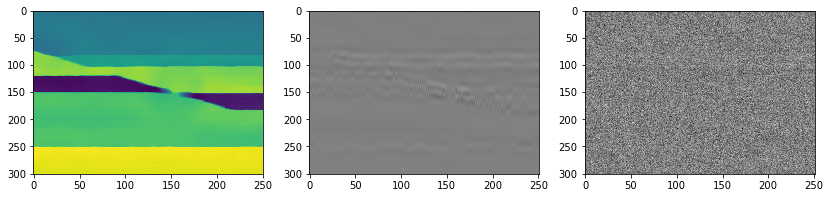

In [11]:
# Bregman with L-ADMM (Blockiness-promoting inversion with isotropic TV)
sigma = .2
l1 = L21(ndim=2)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

# approach with norms of 2 operators - not sure it has any meaning...
#L1 = np.real((Lop.H*Lop).eigs(neigs=1, which='LM')[0])
#L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
#tau = 0.537669 # 1. / L1 # optimal tau=1/maxeig(Lop^H Lop)
#mu = 0.0665 # 0.99 * tau / L # optimal mu=tau/maxeig(Dop^H Dop)

# most common approach
L = 8 # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

mb = Bregman(l2, l1, mback.ravel(), LinearizedADMM, 
             A=Dop, alpha=sigma,
             niterouter=10, 
             tolf=(dn.size * sigman ** 2) / 2.,# Morozov discrepancy
             show=True, **dict(tau=tau, mu=mu, niter=100))
dinv = Lop*mb

mb = mb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

print('RRE=', RRE(m.ravel(), mb.ravel()))
print('PSNR=', PSNR(m.ravel(), mb.ravel()))

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs[0].imshow(mb)
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Additional vector (z): None
tau = 1.000000e+00	mu = 1.237500e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.50393e+00   1.876e+01   4.023e+00   0.000e+00       2.278e+01
     2   7.51006e+00   1.519e+01   4.699e+00   0.000e+00       1.989e+01
     3   7.51475e+00   1.447e+01   4.549e+00   0.000e+00       1.902e+01
     4   7.51769e+00   1.433e+01   4.229e+00   0.000e+00       1.856e+01
     5   7.51885e+00   1.434e+01   3.952e+00   0.000e+00       1.829e+01
     6   7.51875e+00   1.438e+01   3.735e+00   0.000e+00       1.811e+01
     7   7.51830e+00   1.442e+01   3.554e+00   0.000e+00       1.797e+01
     8   7.51814e+00   1.445e+01   3

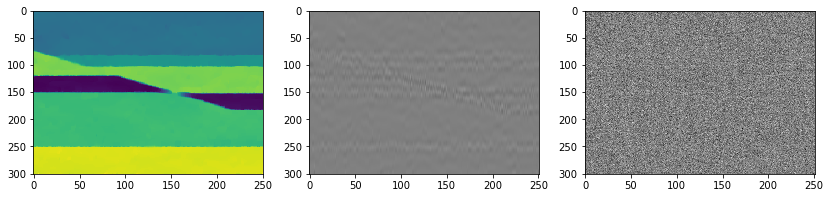

In [12]:
# Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.01
l1 = L21(ndim=2, sigma=sigma)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8. # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

mpd = PrimalDual(l2, l1, Dop, mback.ravel(), tau=tau, mu=mu, 
                 theta=1., niter=100, show=True)
dinv = Lop*mpd

mpd = mpd.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

print('RRE=', RRE(m.ravel(), mpd.ravel()))
print('PSNR=', PSNR(m.ravel(), mpd.ravel()))

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs[0].imshow(mpd)
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

Bregman
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L21.L21'>
Linear operator (A): <class 'pylops.basicoperators.VStack.VStack'>
Inner Solver: <function PrimalDual at 0x1a244ed730>
alpha = 5.000000e-02	tolf = 1.000000e-10	tolx = 1.000000e-10
niter = 5

   Itn       x[0]          f           g       J = f + g
     1   7.50190e+00   1.563e+01   9.900e+00   2.553e+01
     2   7.51036e+00   1.487e+01   1.117e+01   2.604e+01
     3   7.54172e+00   1.477e+01   1.157e+01   2.634e+01
     4   7.54738e+00   1.466e+01   1.210e+01   2.676e+01
     5   7.55802e+00   1.450e+01   1.313e+01   2.763e+01

Total time (s) = 118.68
---------------------------------------------------------

RRE= 0.001774295831096759
PSNR= 51.98684681690011


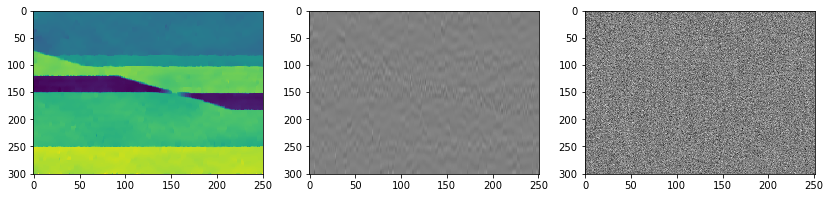

In [13]:
# Bregman with Primal-dual (Blockiness-promoting inversion with isotropic TV)
sigma = 0.05
l1 = L21(ndim=2)
l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')

L = 8 # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 / (tau * L)

mpdb_hist = []
mpdb = Bregman(l2, l1, mback.ravel(), PrimalDual, A=Dop, 
               niterouter=5, alpha=sigma, 
               #tolf=(dn.size * sigman ** 2) / 2.,# Morozov discrepancy
               bregcallback=lambda x: callback(x, mpdb_hist),
               show=True, **dict(tau=tau, mu=mu, theta=1., niter=100))
dinv = Lop*mpdb

mpdb = mpdb.reshape(nt0, nx)
dinv = dinv.reshape(nt0, nx)

print('RRE=', RRE(m.ravel(), mpdb.ravel()))
print('PSNR=', PSNR(m.ravel(), mpdb.ravel()))

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs[0].imshow(mpdb)
axs[0].axis('tight')
axs[1].imshow(d-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[1].axis('tight');
axs[2].imshow(dn-dinv, cmap='gray', vmin=-0.1, vmax=0.1)
axs[2].axis('tight');

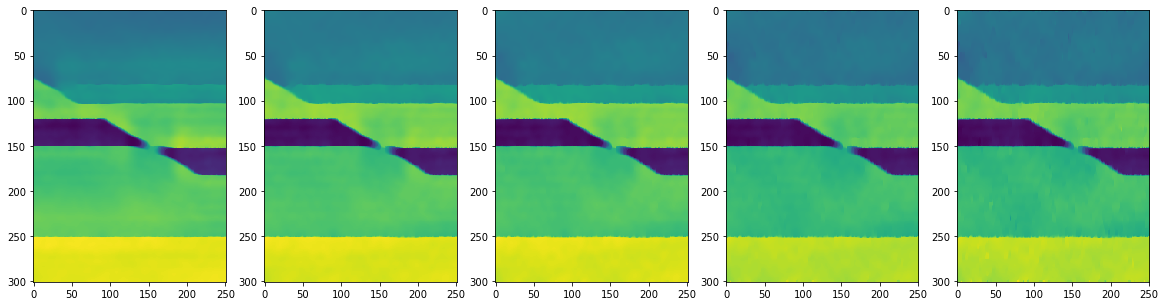

In [14]:
fig, axs = plt.subplots(1, len(mpdb_hist), figsize=(4*len(mpdb_hist), 5))
for i, mh in enumerate(mpdb_hist):
    mh = np.real(mh.reshape(mpdb.shape))
    axs[i].imshow(mh, vmin=mh.min(), vmax=mh.max())
    axs[i].axis('tight');

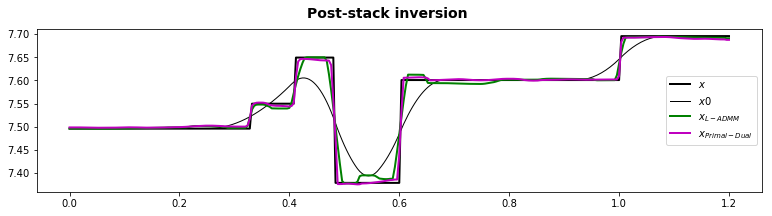

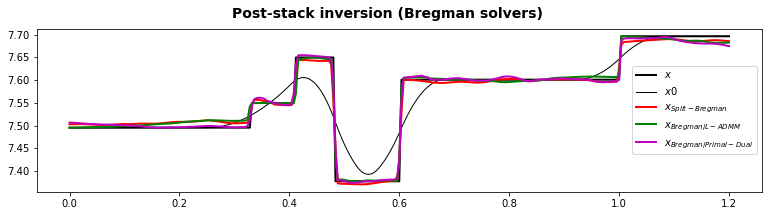

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(13, 3))
fig.suptitle('Post-stack inversion', fontsize=14, fontweight='bold')
ax.plot(t0, m[:, nx//4], 'k', lw=2, label=r'$x$')
ax.plot(t0, mback[:, nx//4], 'k', lw=1, label=r'$x0$')
#ax.plot(t0, minv[:, nx//4], 'b', lw=1, label=r'$x_{L2}$')
ax.plot(t0, mladmm[:, nx//4], 'g', lw=2, label=r'$x_{L-ADMM}$')
ax.plot(t0, mpd[:, nx//4], 'm', lw=2, label=r'$x_{Primal-Dual}$')
ax.legend(loc='right');

fig, ax = plt.subplots(1, 1, figsize=(13, 3))
fig.suptitle('Post-stack inversion (Bregman solvers)', fontsize=14, fontweight='bold')
ax.plot(t0, m[:, nx//4], 'k', lw=2, label=r'$x$')
ax.plot(t0, mback[:, nx//4], 'k', lw=1, label=r'$x0$')
ax.plot(t0, msb[:, nx//4], 'r', lw=2, label=r'$x_{Split-Bregman}$')
ax.plot(t0, mb[:, nx//4], 'g', lw=2, label=r'$x_{Bregman/L-ADMM}$')
ax.plot(t0, mpdb[:, nx//4], 'm', lw=2, label=r'$x_{Bregman/Primal-Dual}$')
ax.legend(loc='right');

## 2D Post-stack  segmentation

Let's start by taking one of our previous inversion results and use it as input to a segmentation algorithm

In [16]:
cl = np.unique(m)
print(cl)
ncl = len(cl)
cldict = {cl[i]:i for i in range(ncl)}

u,inv = np.unique(m, return_inverse = True)
mcl = np.array([cldict[x] for x in u])[inv].reshape(m.shape)

[7.37775891 7.49554194 7.54960917 7.60090246 7.64969262 7.69621264]


In [17]:
segpd_early, segpd_classes_early = Segment(mpdb, cl, 1., 1e-5, niter=10, 
                                           show=True, kwargs_simplex=dict(engine='numba', maxiter=30))

segpd, segpd_classes = Segment(mpdb, cl, 1., 1e-5, niter=200, 
                               show=True,  kwargs_simplex=dict(engine='numba', maxiter=10))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.55904e-01   1.000e+00   6.880e-04   6.379e+02       6.389e+02
     2   1.45142e-01   1.000e+00   1.373e-03   5.822e+02       5.832e+02
     3   1.34381e-01   1.000e+00   2.057e-03   5.265e+02       5.275e+02
     4   1.23620e-01   1.000e+00   2.741e-03   4.708e+02       4.718e+02
     5   1.12859e-01   1.000e+00   3.359e-03   4.175e+02       4.185e+02
     6   1.02097e-01   1.000e+00   3.924e-03   3.800e+02       3.810e+02
     7   9.13358e-02   1.000e+00   4.345e-03   3.516e+02       3.526e+02
     8

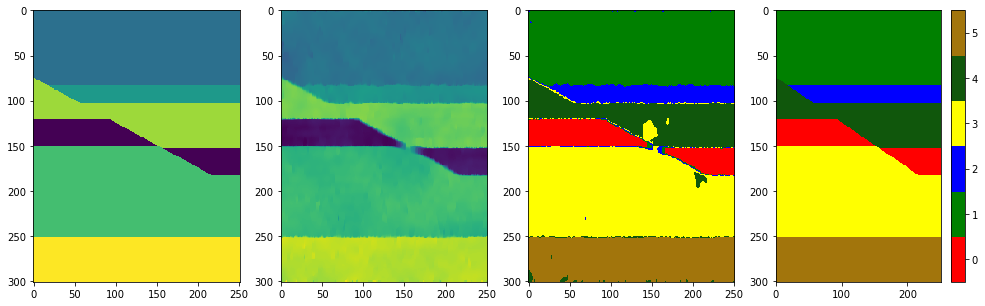

In [18]:
cmap_facies = \
    LinearSegmentedColormap.from_list('name', ['red', 'green', 'blue', 'yellow',
                                               '#11570C', '#A2750C'], 6)

fig, axs = plt.subplots(1, 4, figsize=(17, 5))
axs[0].imshow(m)
axs[0].axis('tight')
axs[1].imshow(mpdb)
axs[1].axis('tight')
im=axs[2].imshow(segpd_classes_early, cmap=cmap_facies, vmin=-0.5, vmax=5.5)
axs[2].axis('tight');
im=axs[3].imshow(mcl, cmap=cmap_facies, vmin=-0.5, vmax=5.5)
axs[3].axis('tight');
plt.colorbar(im);

[1600. 1800. 1900. 2000. 2100. 2200.]


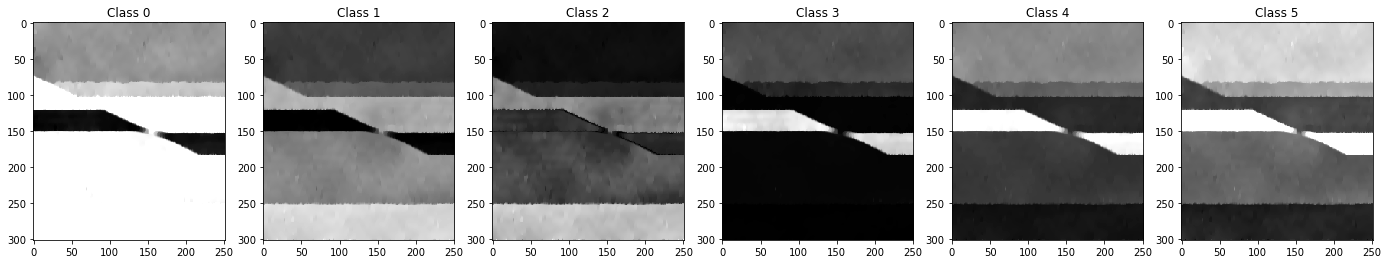

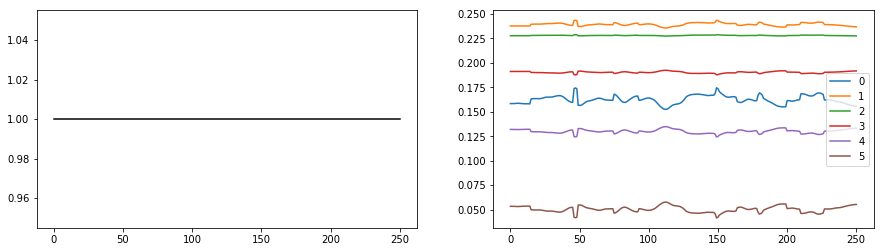

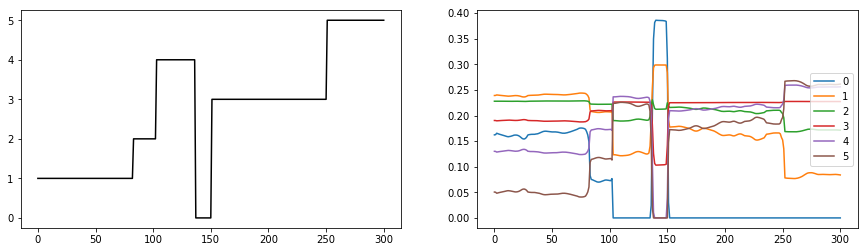

In [19]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd_early[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[20], 'k')
for icl in range(ncl):
    axs[1].plot(segpd_early.reshape(nt0, nx, ncl)[20, :, icl], label=icl)
axs[1].legend(loc='right')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[:, nx//2], 'k')
for icl in range(ncl):
    axs[1].plot(segpd_early.reshape(nt0, nx, ncl)[:, nx//2, icl], label=icl)
axs[1].legend(loc='right');

print(np.exp(cl))

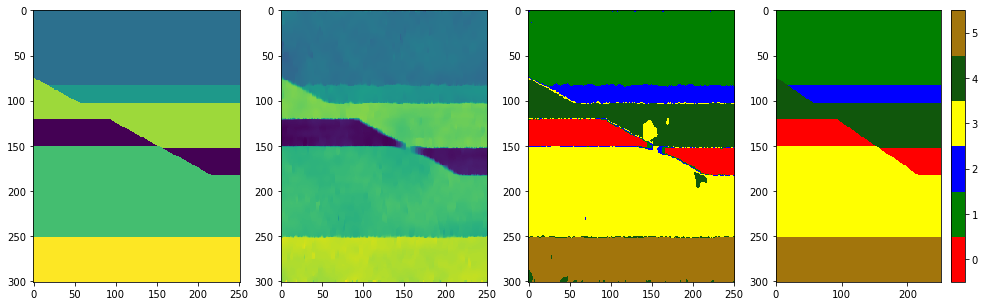

In [20]:
fig, axs = plt.subplots(1, 4, figsize=(17, 5))
axs[0].imshow(m)
axs[0].axis('tight')
axs[1].imshow(mpdb)
axs[1].axis('tight')
im=axs[2].imshow(segpd_classes, cmap=cmap_facies, vmin=-0.5, vmax=5.5)
axs[2].axis('tight');
im=axs[3].imshow(mcl, cmap=cmap_facies, vmin=-0.5, vmax=5.5)
axs[3].axis('tight');
plt.colorbar(im);

[1600. 1800. 1900. 2000. 2100. 2200.]


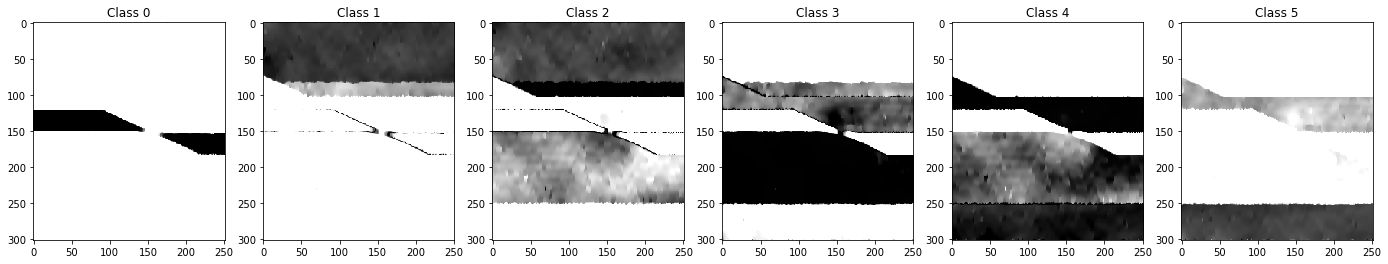

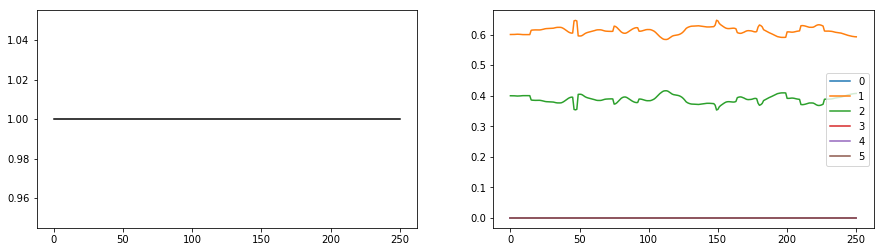

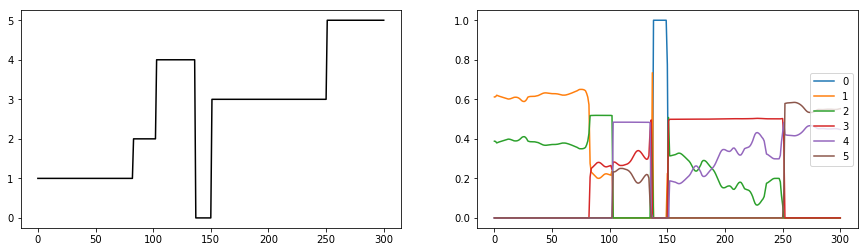

In [21]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(segpd[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[20], 'k')
for icl in range(ncl):
    axs[1].plot(segpd.reshape(nt0, nx, ncl)[20, :, icl], label=icl)
axs[1].legend(loc='right')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[:, nx//2], 'k')
for icl in range(ncl):
    axs[1].plot(segpd.reshape(nt0, nx, ncl)[:, nx//2, icl], label=icl)
axs[1].legend(loc='right');

print(np.exp(cl))

In [22]:
np.savez('/Users/matteoravasi/Desktop/Poststack_segmentation/fault.npz', m=m, mpd=mpd, d=d,
         segpd_classes=segpd_classes, segpd=segpd, cl=cl)

## 2D Post-stack joint inversion & segmentation

**Inversion**

$$
m^{k+1} = min_x  (\frac{1}{2}||Ax-f||_2^2 + \delta ||\hat{V}x-\hat{c}||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

combining the first two terms

$$
m^{k+1} = min_x  (\frac{1}{2}||A^1x-f^1||_2^2 - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $A^1 = [A, \sqrt{2\delta}\hat{V}]^T$ and $f^1 = [f, \sqrt{2\delta}\hat{c}]^T$ and $\hat{V}=[diag(\sqrt{v_1}), ..., diag(\sqrt{v_N})]$ and $\hat{c}=[\sqrt{v_1}c_1, ..., \sqrt{v_N}c_N]$


**Segmentation**


$$
v^{k+1} = min_{v \in C}  (v^T(\delta g - \beta q^k) - \alpha p^{kT}x) + \alpha ||Dx||_{2,1} 
$$

where $C$ is a simplex.

Let's start with LinearizedADMM

# regularization knobs
alpha=0.01
beta=0.001
delta = 4.

#alpha = 0.8
#beta = 0.001
#delta = 0.01

niter = 4
tolstop = 0.

# TV regularization term
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
l1_m = L21(ndim=2, sigma=alpha)

p = np.zeros_like(m).ravel()
q = np.zeros(ncl*m.size)
v = np.zeros(ncl*m.size)
minv = mback.copy().ravel()

for iiter in range(niter):
    print('Iteration %d...' % iiter)
    minvold = minv.copy()
    vold = v.copy()

    #############
    # Inversion #  
    #############
    if iiter == 0:
        # define misfit term
        l2 = L2(Op=Lop, b=dn.ravel(), niter=10, warm=True)

        # steps
        L = 8
        tau = 1.
        mu = 0.99 * tau / L 

        # solve
        minv = LinearizedADMM(l2, l1_m, Dop, tau=tau, mu=mu, 
                              x0=mback.ravel(), niter=100)[0]
        minv = np.real(minv)
        dinv = Lop * minv
        
        # Update p
        l2_grad = L2(Op=Lop, b=dn.ravel())
        dp = (1./alpha) * l2_grad.grad(minv)
        p -= np.real(dp)      
    else:
        # define misfit term
        v = v.reshape((m.size, ncl))

        L1op = VStacklop([Lop] + [Diagonal(np.sqrt(2.*delta)*np.sqrt(v[:, icl])) for icl in range(ncl)])
        d1 = np.hstack([dn.ravel(), (np.sqrt(2.*delta)*(np.sqrt(v) * cl[np.newaxis, :]).T).ravel()])
        l2 = L2(Op=L1op, b=d1, niter=10, warm=True, q=p, alpha=-alpha)

        # steps
        L = 8.
        tau = 1.
        mu = 0.99 * tau / L 

        # solve
        minv = LinearizedADMM(l2, l1_m, Dop, tau=tau, mu=mu, 
                              x0=mback.ravel(), niter=100)[0]
        dinv = Lop * minv
        
        # Update p
        l2_grad = L2(Op=L1op, b=d1)
        dp = (1./alpha) * l2_grad.grad(minv)
        #dp = (1./alpha) * (Lop.H * (Lop * minv.ravel() - dn.ravel()) - 
        #                    2* delta * np.sum([v[:, icl] * (minv.ravel() - cl[icl]) 
        #                    for icl in range(ncl)]))
        p -= dp
    
    
    ################
    # Segmentation #  
    ################
    v, vcl = Segment(minv, cl, 2 * delta, 2 * beta, z=-beta*q, 
                     niter=10, simplex_engine='numba', callback=None, show=False)
    
    # Update q
    dq = (delta/beta) * ((minv.ravel() - cl[:, np.newaxis]) ** 2).ravel()
    q -= dq
    
    fig, axs = plt.subplots(1, 5, figsize=(14, 3))
    fig.suptitle('Iteration %d'% iiter)
    axs[0].imshow(m.reshape(nt0, nx), vmin=m.min(), vmax=m.max())
    axs[0].axis('tight')
    axs[1].imshow(minv.reshape(nt0, nx), vmin=m.min(), vmax=m.max())
    axs[1].axis('tight')
    axs[2].imshow(d-dinv.reshape(nt0, nx), cmap='gray', vmin=-0.1, vmax=0.1)
    axs[2].axis('tight')
    axs[3].imshow(dn-dinv.reshape(nt0, nx), cmap='gray', vmin=-0.1, vmax=0.1)
    axs[3].axis('tight')
    axs[4].imshow(vcl.reshape(nt0, nx))
    axs[4].axis('tight')def callback(x, xhist):
    xhist.append(x)
        
    # Monitor cost functions
    print('f=', L2(Op=Lop, b=dn.ravel())(minv))
    print('||v-v_old||_2=', np.linalg.norm(v.ravel() - vold.ravel()))
    print('||m-m_old||_2=', np.linalg.norm(minv.ravel() - minvold.ravel()))

    # Check stopping criterion 
    if np.linalg.norm(v.ravel()-vold.ravel()) < tolstop:
        break

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(minv.reshape(nt0, nx))
axs[0].axis('tight')
im=axs[1].imshow(vcl.reshape(nt0, nx), cmap=cmap_facies, vmin=-0.5, vmax=5.5)
axs[1].axis('tight');
plt.colorbar(im);

and PrimalDual

Iteration 0...
f= 14.70658244457209
||v-v_old||_2= 273.71242717224237
||m-m_old||_2= 7.504517040796805
RRE= 0.001515362795423219
PSNR= 52.664076386473425
Iteration 1...
f= 15.015366451036567
||v-v_old||_2= 12.067989781186931
||m-m_old||_2= 1.860228193713799
RRE= 0.001400051221908601
PSNR= 52.99981193979878
Iteration 2...
f= 15.04835500650813
||v-v_old||_2= 6.0987892877329495
||m-m_old||_2= 0.5468645523174642
RRE= 0.0014411212522668446
PSNR= 52.8742641584292
Iteration 3...
f= 15.044422188258983
||v-v_old||_2= 3.498859878139292
||m-m_old||_2= 0.23908702868521464
RRE= 0.0014622033038296826
PSNR= 52.81121187584805


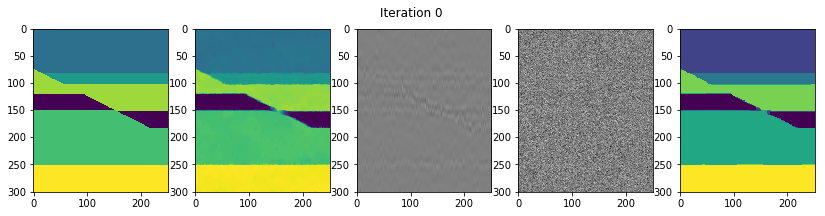

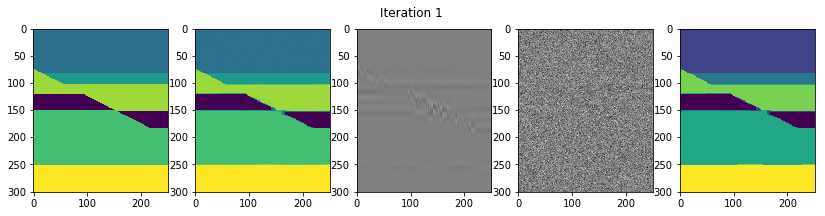

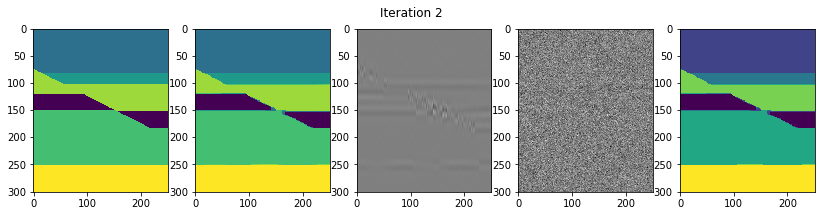

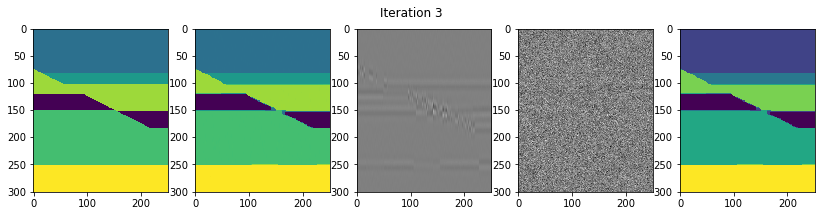

In [23]:
# regularization knobs

# good first iteration but little improvement
alpha=0.01
beta=0.1
delta = 10.

# improvement but overall not very good
#alpha = 0.03
#beta = 0.001
#delta = 5.

niter = 4
tolstop = 0.

# TV regularization term
Dop = Gradient(dims=(nt0, nx), edge=True, dtype=Lop.dtype, kind='forward')
l1_m = L21(ndim=2, sigma=alpha)

p = np.zeros_like(m).ravel()
q = np.zeros(ncl*m.size)
v = np.zeros(ncl*m.size)
minv = mback.copy().ravel()
rre = np.zeros(niter)
psnr = np.zeros(niter)

for iiter in range(niter):
    print('Iteration %d...' % iiter)
    minvold = minv.copy()
    vold = v.copy()

    #############
    # Inversion #  
    #############
    if iiter == 0:
        # define misfit term
        l2 = L2(Op=Lop, b=dn.ravel(), niter=20, warm=True)

        # steps
        L = 8
        #tau = .99 / np.sqrt(L)
        #mu = .99 / np.sqrt(L)
        tau = 1.
        mu = 0.99 / (tau * L)

   
        minv = PrimalDual(l2, l1_m, Dop, x0=mback.ravel(), 
                          tau=tau, mu=mu, theta=1., niter=100)
        minv = np.real(minv)
        dinv = Lop * minv

        # Update p
        l2_grad = L2(Op=Lop, b=dn.ravel())
        dp = (1./alpha) * l2_grad.grad(minv)
        p -= np.real(dp)      
    else:
        # define misfit term
        v = v.reshape((m.size, ncl))

        L1op = VStacklop([Lop] + [Diagonal(np.sqrt(2.*delta)*np.sqrt(v[:, icl])) for icl in range(ncl)])
        d1 = np.hstack([dn.ravel(), (np.sqrt(2.*delta)*(np.sqrt(v) * cl[np.newaxis, :]).T).ravel()])
        l2 = L2(Op=L1op, b=d1, niter=20, warm=True, q=p, alpha=-alpha)

        # steps
        L = 8.
        #tau = .99 / np.sqrt(L)
        #mu = .99 / np.sqrt(L)
        tau = 1.
        mu = 0.99 / (tau * L)

        # solve
        minv = PrimalDual(l2, l1_m, Dop, x0=mback.ravel(), 
                          tau=tau, mu=mu, theta=1., niter=100)
        dinv = Lop * minv
        
        # Update p
        l2_grad = L2(Op=L1op, b=d1)
        dp = (1./alpha) * l2_grad.grad(minv)
        #dp = (1./alpha) * (Lop.H * (Lop * minv.ravel() - dn.ravel()) - 
        #                    2* delta * np.sum([v[:, icl] * (minv.ravel() - cl[icl]) 
        #                    for icl in range(ncl)]))
        p -= dp
    
    ################
    # Segmentation #  
    ################
    v, vcl = Segment(minv, cl, 2 * delta, 2 * beta, z=-beta*q, 
                     niter=80, callback=None, show=False,
                     kwargs_simplex=dict(engine='numba', maxiter=200))
    
    # Update q
    dq = (delta/beta) * ((minv.ravel() - cl[:, np.newaxis]) ** 2).ravel()
    q -= dq
    
    fig, axs = plt.subplots(1, 5, figsize=(14, 3))
    fig.suptitle('Iteration %d'% iiter)
    axs[0].imshow(m.reshape(nt0, nx), vmin=m.min(), vmax=m.max())
    axs[0].axis('tight')
    axs[1].imshow(minv.reshape(nt0, nx), vmin=m.min(), vmax=m.max())
    axs[1].axis('tight')
    axs[2].imshow(d-dinv.reshape(nt0, nx), cmap='gray', vmin=-0.1, vmax=0.1)
    axs[2].axis('tight')
    axs[3].imshow(dn-dinv.reshape(nt0, nx), cmap='gray', vmin=-0.1, vmax=0.1)
    axs[3].axis('tight')
    axs[4].imshow(vcl.reshape(nt0, nx))
    axs[4].axis('tight')
    
    # Monitor cost functions
    print('f=', L2(Op=Lop, b=dn.ravel())(minv))
    print('||v-v_old||_2=', np.linalg.norm(v.ravel() - vold.ravel()))
    print('||m-m_old||_2=', np.linalg.norm(minv.ravel() - minvold.ravel()))
    
    # Monitor quality of reconstruction
    rre[iiter] =RRE(m.ravel(), minv.ravel())
    psnr[iiter] = PSNR(m.ravel(), minv.ravel())
    print('RRE=', rre[iiter])
    print('PSNR=', psnr[iiter])
    
    # Check stopping criterion 
    if np.linalg.norm(v.ravel()-vold.ravel()) < tolstop:
        break

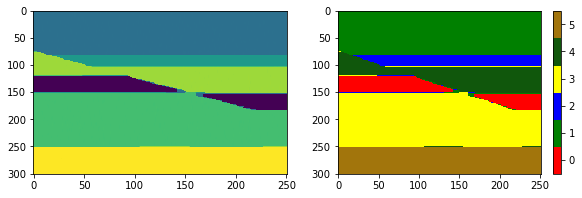

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(minv.reshape(nt0, nx),  vmin=m.min(), vmax=m.max())
axs[0].axis('tight')
im=axs[1].imshow(vcl.reshape(nt0, nx), cmap=cmap_facies, vmin=-0.5, vmax=5.5)
axs[1].axis('tight');
plt.colorbar(im);

[1600. 1800. 1900. 2000. 2100. 2200.]


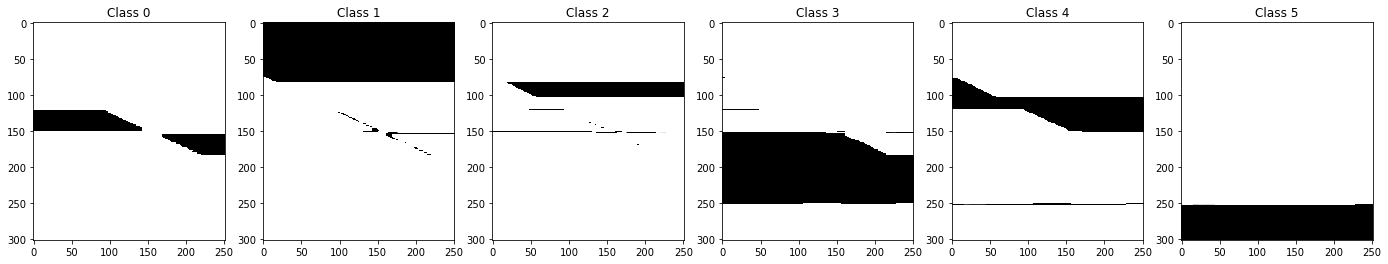

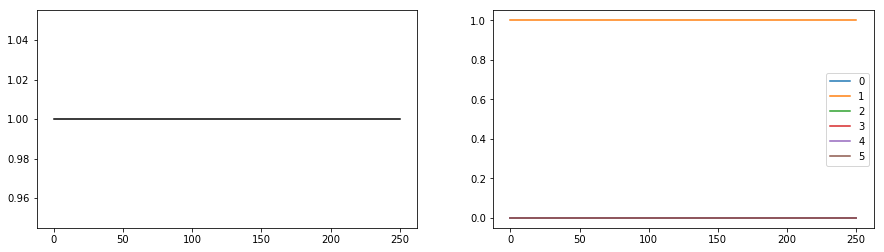

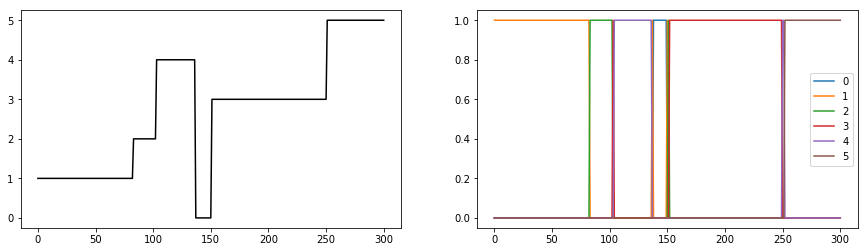

In [31]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    im = axs[icl].imshow(v[:, icl].reshape(nt0, nx), cmap='gray_r')
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[20], 'k')
for icl in range(ncl):
    axs[1].plot(v.reshape(nt0, nx, ncl)[20, :, icl], label=icl)
axs[1].legend(loc='right')

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(mcl[:, nx//2], 'k')
for icl in range(ncl):
    axs[1].plot(v.reshape(nt0, nx, ncl)[:, nx//2, icl], label=icl)
axs[1].legend(loc='right');

print(np.exp(cl))

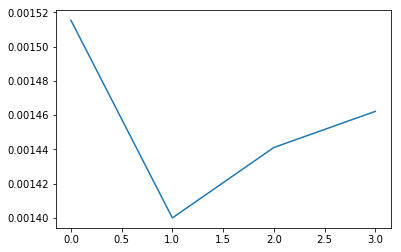

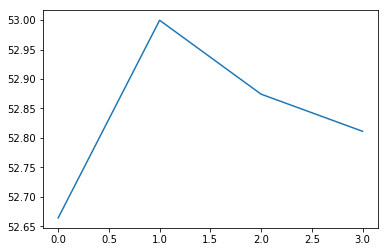

In [25]:
plt.figure()
plt.plot(rre)

plt.figure()
plt.plot(psnr)

In [45]:
np.savez('/Users/matteoravasi/Desktop/Poststack_segmentation/fault_joint.npz', m=m, mpd=mpd, d=d,
         segpd_classes=v.reshape(nt0, nx, ncl), segpd=vcl.reshape(nt0, nx), cl=cl)